<a href="https://colab.research.google.com/github/SoYeoni621/mulcam/blob/master/0224_Thurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None
  
  # 순전파
  def forward(self, x, y):
    self.x = x
    self.y = y
    return x*y

  # 역전파
  # dout: 상류에서 흘러오는 값
  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy
    

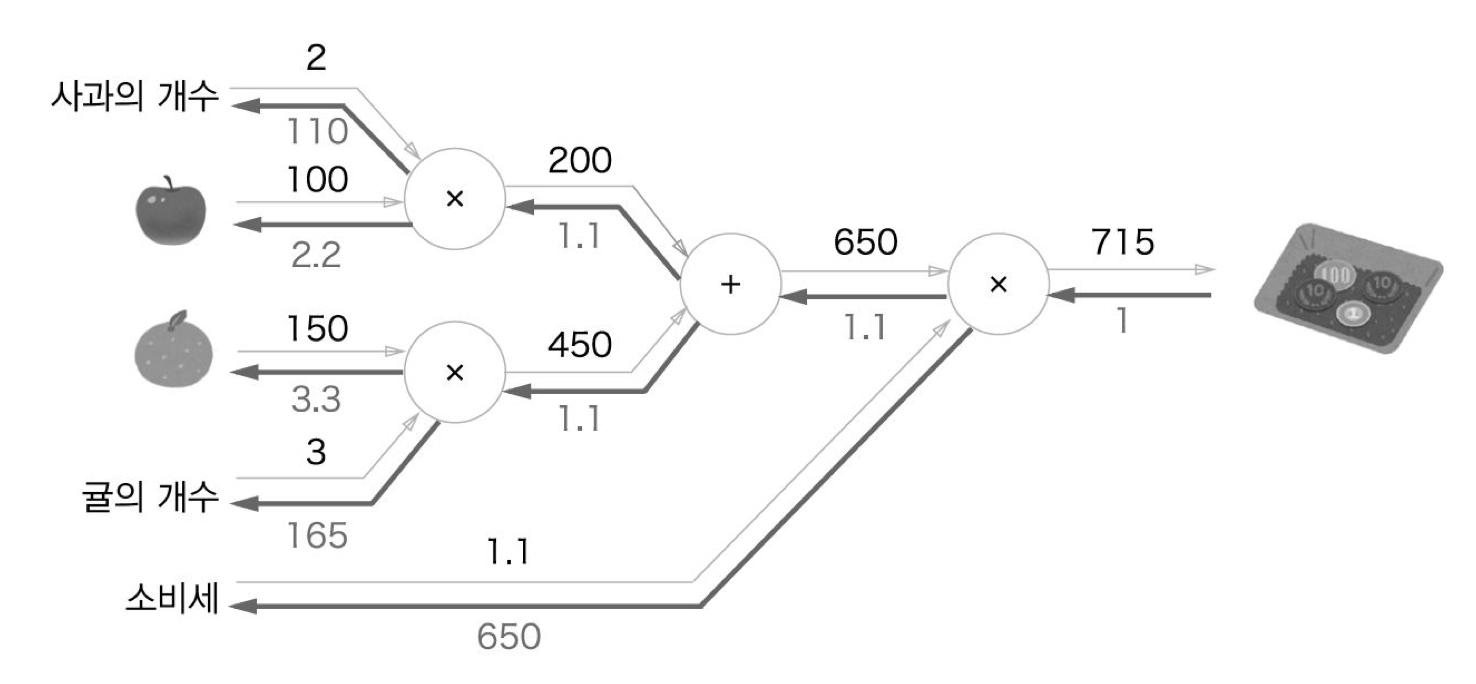

In [3]:
# 위 그림에서 곱셈 노드만 구현
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward (순전파)
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward (역전파)
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice) # 
dapple, dapple_num = mul_apple_layer.backward(dapple_price) # 

print(f"price: {price}")
print(f"dApple: {dapple}")
print(f"dapple_num: {dapple_num}")
print(f"dtax: {dtax}")

price: 220.00000000000003
dApple: 2.2
dapple_num: 110.00000000000001
dtax: 200


In [4]:
# 덧셈 노드 구현
class AddLayer:
  def __init__(self):
    pass
  
  def forward(self, x, y):
    out = x + y
    return out
  
  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

In [5]:
apple = 100
apple_num = 2
mandarin = 150
mandarin_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_mandarin_layer = MulLayer()
add_apple_mandarin_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
mandarin_price = mul_mandarin_layer.forward(mandarin, mandarin_num)
fruits_price = add_apple_mandarin_layer.forward(apple_price, mandarin_price)
price = mul_tax_layer.forward(tax, fruits_price)

# backward
dprice = 1
dtax, dfruits_price = mul_tax_layer.backward(dprice)
print(dfruits_price, dtax)
dapple_price, dmandarin_price = add_apple_mandarin_layer.backward(dfruits_price)
dmandarin, dmandarin_num = mul_mandarin_layer.backward(dmandarin_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(f"price: {price}")
print(f"dMandarin: {dmandarin}")
print(f"dmandarin_num: {dmandarin_num}")
print(f"dApple: {dapple}")
print(f"dapple_num: {dapple_num}")
print(f"dtax: {dtax}")


1.1 650
price: 715.0000000000001
dMandarin: 3.3000000000000003
dmandarin_num: 165.0
dApple: 2.2
dapple_num: 110.00000000000001
dtax: 650


# Relu 역전파

In [6]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    
    return dout

# Sigmoid 역전파

In [7]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [8]:
class Sigmoid:
  def __init__(self):
    self.out = None
  
  def forward(self, x):
    self.out = sigmoid(x)
    return self.out

  def backward(self, dout):
    dx = dout * (1 - self.out) * self.out
    return dx

# Affine 계층

In [9]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(self.x, self.W) + self.b

    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    return dx

In [10]:
def softmax(x):
  exp_x = np.exp(x)
  sum_exp_x = np.sum(exp_x, axis=-1).reshape(-1, 1)
  y = exp_x / sum_exp_x

  return y

In [11]:
def cross_entropy_error_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size) # 1차원이면 나눌 batch가 없으므로 2차원으로 만들어준다.
  batch_size = y.shape[0]

  delta = 1e-7
  return -np.sum(t * np.log(y + delta))/batch_size

In [12]:
class SoftmaxWithloss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0] # 샘플의 개수

    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1

    return dx

In [13]:
def _numerical_gradient_no_batch(f, x):
  h = 1e-4
  grad = np.zeros_like(x) #x와 같은 배열 생성

  for idx in range(x.size):
    tmp_val = x[idx]

    #f(x+h)
    x[idx] = float(tmp_val) + h
    fxh1 = f(x)

    #f(x-h)
    x[idx] = float(tmp_val) - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)  #미분/기울기
    x[idx] = tmp_val   # 값 복원
 
  return grad

In [14]:
def numerical_gradient(f, X):
  if X.ndim == 1:
    return _numerical_gradient_no_batch(f, X)
  else:
    grad = np.zeros_like(X)

    for idx, x in enumerate(X):
      grad[idx] = _numerical_gradient_no_batch(f, x)

    return grad

In [21]:
from collections import OrderedDict


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 파라미터 랜덤 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers["Affine2"] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithloss()

    def predict(self, x):
      for layer in self.layers.values():
        x = layer.forward(x)

      return x

    def loss(self, x, t):
      y = self.predict(x)
      return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      if t.ndim != 1:
        t = np.argmax(t, axis=1)

      accuracy = np.sum(y == t)/float(x.shape[0])
      return accuracy

    def numerical_gradient(self, x, t):
        #목적 함수 - Cross Entropy 
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        #목적함수에 대해 각 파라메터 별로 편미분
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
      self.loss(x, t)

      dout = 1
      dout = self.lastLayer.backward(dout)

      layers = list(self.layers.values())
      layers.reverse()

      for layer in layers:
        dout = layer.backward(dout)

      grads = {}
      grads['W1'] = self.layers['Affine1'].dW
      grads['b1'] = self.layers['Affine1'].db
      grads['W2'] = self.layers['Affine2'].dW
      grads['b2'] = self.layers['Affine2'].db

      return grads

In [22]:
import pickle
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
  def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row  in enumerate(T):
      row[X[idx]] = 1

      return T

  with open('/content/drive/MyDrive/딥러닝/mnist.pkl', 'rb') as f:
      dataset = pickle.load(f)


  if normalize:
      for key in ('train_img', 'test_img'):
        dataset[key] = dataset[key].astype(np.float32)
        dataset[key] /= 255.0
    
  if one_hot_label:
    dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
    dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

  if not flatten:
    for key in ('train_img', 'test_img'):
      dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

  return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [23]:
 # 데이터 로딩 - 원핫 형식으로 
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

In [24]:
# 2층 신경망 객체 생성
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [25]:
iters_num = 10000 #반복 횟수
train_size = x_train.shape[0] #훈련 데이터 크기
batch_size = 100 #미니배치 사이즈
learning_rate = 0.01 #학습률

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1) #1에폭당 반복 횟수, 최소 한번


In [26]:
for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size) # 랜덤하게 0~train_size-1 안에 있는 숫자를 batch_size만큼 가져옴
  x_batch = x_train[batch_mask] # 랜덤하게 batch_size만큼 훈련 데이터에서 선택
  y_batch = y_train[batch_mask] # 랜덤하게 batch_size만큼 라벨에서 선택

  # 기울기 계산
  grad = network.gradient(x_batch, y_batch)
  
  # 매개 변수 갱신 (ex. w = w - learning_rate * 기울기(미분값))
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # 학습 경과 기록(loss구하기)
  loss = network.loss(x_batch, y_batch)
  train_loss_list.append(loss) # loss 값을 train_loss_list 에 추가
  if i % iter_per_epoch == 0:

    # 파라미터 업데이트 후의 정확도 계산
    train_acc = network.accuracy(x_train, y_train)
    test_acc = network.accuracy(x_test, y_test)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"loss {loss}, train_accuracy {train_acc}, test_accuracy {test_acc}")

loss -0.0, train_accuracy 0.51045, test_accuracy 0.5198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, train_accuracy 0.9999833333333333, test_accuracy 0.9999
loss nan, 